In [1]:
git bash

SyntaxError: invalid syntax (<ipython-input-1-9b0f23a1eb1f>, line 1)

In [1]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.models import Sequential
from keras.utils.np_utils import to_categorical  # 레이블을 단일 열로 변환하는 데 사용
import keras
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

Using TensorFlow backend.


In [2]:
Basepath = "../skin-cancer-mnist-ham10000"

print(os.listdir('../skin-cancer-mnist-ham10000'))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


In [3]:
base_skin_dir = os.path.join('../', './skin-cancer-mnist-ham10000')
print(base_skin_dir)


.././skin-cancer-mnist-ham10000


두 폴더의 이미지를 하나의 사전으로 병합합니다

In [4]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [5]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

메타데이터의 csv에서 읽기

In [6]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

일부 새 열(이미지 경로, 사람이 읽을 수 있는 이름)을 만들고 검토

In [7]:
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
print(tile_df.sample(5))

print("-" * 160)

        lesion_id      image_id     dx    dx_type   age     sex  \
9725  HAM_0004376  ISIC_0024843  akiec      histo  70.0  female   
6059  HAM_0003024  ISIC_0024768     nv  follow_up  35.0  female   
4540  HAM_0001659  ISIC_0026564     nv  follow_up  35.0    male   
3817  HAM_0004625  ISIC_0029346     nv  follow_up  40.0    male   
7914  HAM_0000443  ISIC_0034271     nv      histo  35.0  female   

         localization                                               path  \
9725             face  .././skin-cancer-mnist-ham10000\HAM10000_image...   
6059            trunk  .././skin-cancer-mnist-ham10000\HAM10000_image...   
4540  lower extremity  .././skin-cancer-mnist-ham10000\HAM10000_image...   
3817  upper extremity  .././skin-cancer-mnist-ham10000\HAM10000_image...   
7914             back  .././skin-cancer-mnist-ham10000\HAM10000_image...   

              cell_type  cell_type_idx  
9725  Actinic keratoses              0  
6059   Melanocytic nevi              4  
4540   Melanocyti

데이터 집합에 대한 일반 통계 가져오기

In [8]:
print(tile_df.describe(exclude=[np.number]))

          lesion_id      image_id     dx dx_type    sex localization  \
count         10015         10015  10015   10015  10015        10015   
unique         7470         10015      7       4      3           15   
top     HAM_0003789  ISIC_0032802     nv   histo   male         back   
freq              6             1   6705    5340   5406         2192   

                                                     path         cell_type  
count                                               10015             10015  
unique                                              10015                 7  
top     .././skin-cancer-mnist-ham10000\HAM10000_image...  Melanocytic nevi  
freq                                                    1              6705  


여러 셀 유형의 분포 확인

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

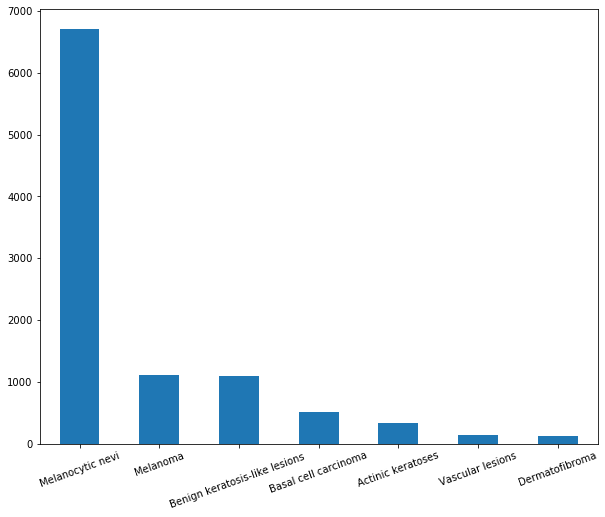

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
plt.xticks(rotation=20)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

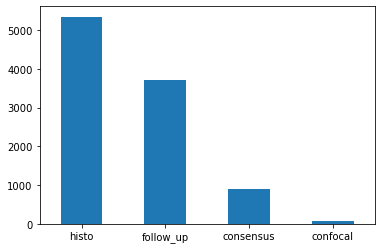

In [10]:
tile_df['dx_type'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

이미지를 100 * 75로 동일하게 이미지 변환 작업

In [11]:
tile_df['image'] = tile_df['path'].map(
    lambda x: np.asarray(Image.open(x).resize((100, 75))))

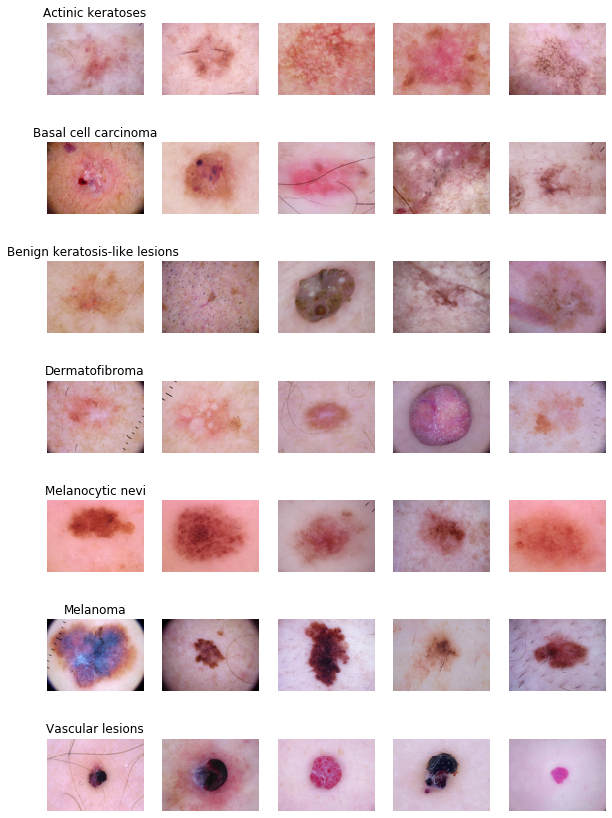

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize=(10, 15))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

'nv': 'Melanocytic nevi',                        멜라닌 세포 모반

'mel': 'Melanoma',                               흑생종

'bkl': 'Benign keratosis-like lesions ',         지루성 각화증

'bcc': 'Basal cell carcinoma',                   기저 세포암

'akiec': 'Actinic keratoses',                    화학 각화증

'vasc': 'Vascular lesions',                      혈관 병변

'df': 'Dermatofibroma'                           피부병

이미지 사이즈 및 사진량

In [13]:
print(tile_df['image'].map(lambda x: x.shape).value_counts())

(75, 100, 3)    10015
Name: image, dtype: int64


In [14]:
y = tile_df.cell_type_idx

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
    tile_df, y, test_size=0.25)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

레이블에 단일 핫 인코딩 수행

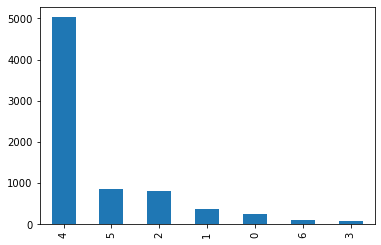

In [15]:
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

y_train_o.value_counts().plot(kind='bar')

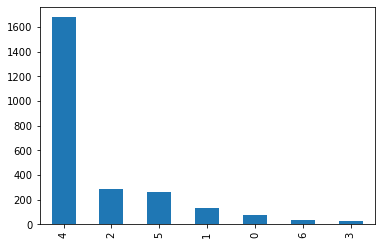

In [16]:
y_test_o.value_counts().plot(kind='bar')

In [17]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

작업: 이 변수를 사용하여 더 많은 실험을 수행작업: RMS 프로펠러와 같은 다른 최적화 도구 사용

In [18]:
batch_size = 32  # 작업: 이 변수를 사용하여 더 많은 실험을 수행
epochs = 12

In [19]:
checkpoint = ModelCheckpoint("best_model2.hdf5", monitor='val_loss', verbose=1,
                             save_best_only=True, mode='auto', period=1)

In [20]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint])

Train on 7511 samples, validate on 2504 samples
Epoch 1/12
7511/7511 [==============================] - 21s 3ms/step - loss: 1.1589 - accuracy: 0.6584 - val_loss: 1.1185 - val_accuracy: 0.6665

Epoch 00001: val_loss improved from inf to 1.11849, saving model to best_model2.hdf5
Epoch 2/12
7511/7511 [==============================] - 16s 2ms/step - loss: 0.8998 - accuracy: 0.6786 - val_loss: 0.8047 - val_accuracy: 0.7009

Epoch 00002: val_loss improved from 1.11849 to 0.80467, saving model to best_model2.hdf5
Epoch 3/12
7511/7511 [==============================] - 16s 2ms/step - loss: 0.8262 - accuracy: 0.6984 - val_loss: 0.8146 - val_accuracy: 0.7073

Epoch 00003: val_loss did not improve from 0.80467
Epoch 4/12
7511/7511 [==============================] - 16s 2ms/step - loss: 0.7560 - accuracy: 0.7217 - val_loss: 0.7437 - val_accuracy: 0.7376

Epoch 00004: val_loss improved from 0.80467 to 0.74367, saving model to best_model2.hdf5
Epoch 5/12
7511/7511 [==============================] 

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9759402054186446
Test accuracy: 0.7364217042922974


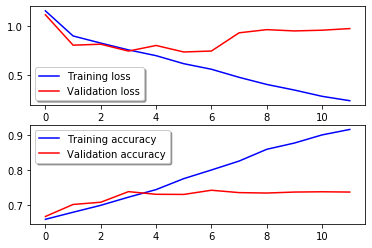

In [22]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

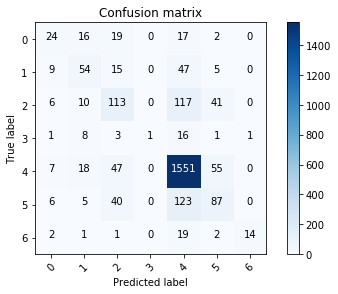

In [24]:
# 유효성 검사 데이터 집합에서 값 예측
y_pred = model.predict(x_test)
# 예측 클래스를 하나의 핫 벡터로 변환
y_pred_classes = np.argmax(y_pred, axis=1)
# 유효성 검사 관찰을 하나의 핫 벡터로 변환
y_true = np.argmax(y_test, axis=1)
# 매트릭스 행렬을 계산하다.
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
# 매트릭스 행렬을 그리다.
plot_confusion_matrix(confusion_mtx, classes=range(7))

In [25]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
model = load_model('best_model2.hdf5')

In [26]:
import cv2

In [27]:
image_labels = {0 : 'akiec', 1 : 'bcc', 2 : 'bkl', 3 : 'df', 4 : 'nv', 5 : 'mel', 6 : 'vasc'}

The Answer is  nv
94.78007555007935
pred    0.947801
Name: 4, dtype: float32


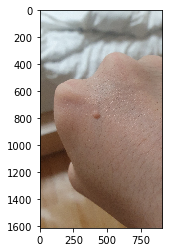

In [28]:
img = cv2.imread("./me.jpg", cv2.IMREAD_COLOR)

b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge

plt.imshow(img2)

img = cv2.resize(255-img, (75, 100))

test_num = img.flatten() / 255.0

test_num = test_num.reshape((1, 75, 100, 3))


prediction = model.predict(test_num)
df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')

print('The Answer is ', image_labels[int(model.predict_classes(test_num))])
print(df.iloc[0]['pred']*100)
print(df.iloc[0])

In [29]:
test_list = range(7)
for i in test_list: 
    print(df.iloc[i]*100)

pred    94.780075
Name: 4, dtype: float32
pred    4.153452
Name: 1, dtype: float32
pred    0.988054
Name: 2, dtype: float32
pred    0.045324
Name: 5, dtype: float32
pred    0.023527
Name: 3, dtype: float32
pred    0.005004
Name: 6, dtype: float32
pred    0.004567
Name: 0, dtype: float32


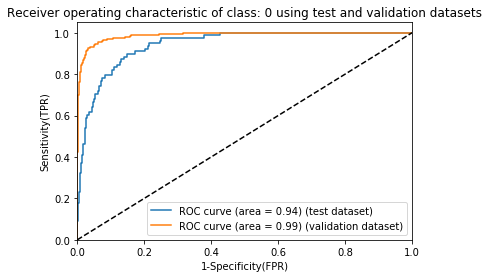

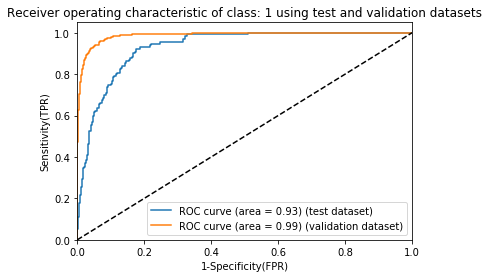

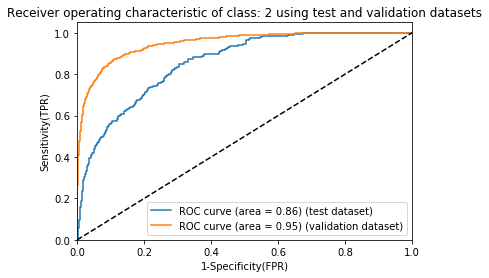

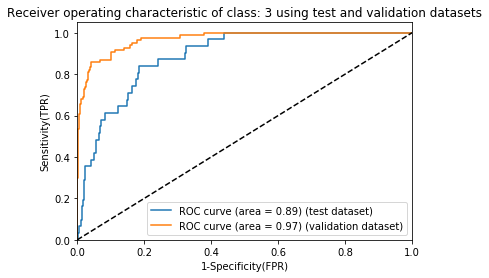

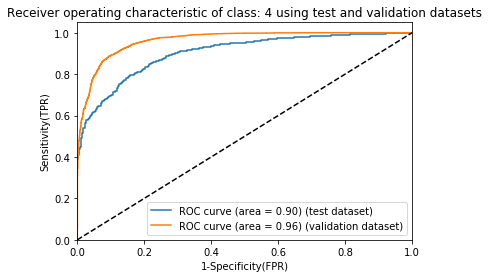

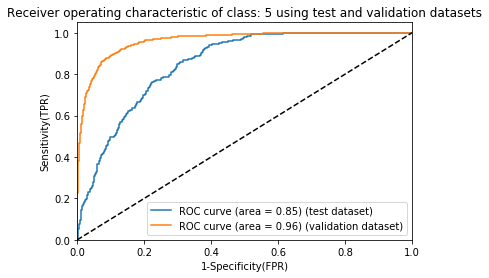

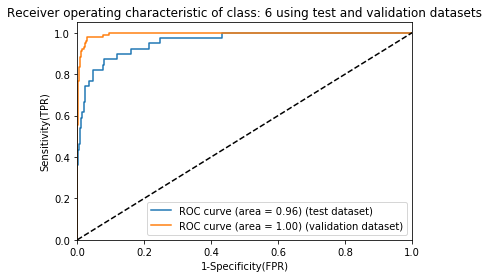

In [37]:
from sklearn.metrics import roc_curve, auc

y_pred_test = model.predict(x_test)
y_pred_val = model.predict(x_train)
num_classes=7

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()
fpr_test = dict()
tpr_test= dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test[:, i], y_pred_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    fpr_val[i], tpr_val[i], _ = roc_curve(y_train[:, i], y_pred_val[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr_test[i], tpr_test[i], label='ROC curve (area = %0.2f) (test dataset)' % roc_auc_test[i])
    plt.plot(fpr_val[i], tpr_val[i], label='ROC curve (area = %0.2f) (validation dataset)' % roc_auc_val[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(FPR)')
    plt.ylabel('Sensitivity(TPR)')
    plt.title('Receiver operating characteristic of class: '+ str(i) + ' using test and validation datasets' )
    plt.legend(loc="lower right")
    plt.show()